In [1]:
# Cell 1 — Install & versions
!pip -q install pandas numpy scikit-learn Sastrawi tqdm joblib

import sys, sklearn, pandas as pd, numpy as np
print("Python :", sys.version)
print("pandas :", pd.__version__)
print("numpy  :", np.__version__)
print("sklearn:", sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.5 MB/s eta 0:00:00
Python : 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
pandas : 2.2.3
numpy  : 1.26.4
sklearn: 1.2.2


In [ ]:
# Cell 2 — Load raw CSV dari Minggu 1
from pathlib import Path
import pandas as pd

RAW_PATH = Path("/kaggle/input/dataset-jkn/mobilejkn_reviews_raw_id20000.csv")
assert RAW_PATH.exists(), f"File tidak ditemukan: {RAW_PATH}"

df_raw = pd.read_csv(RAW_PATH, parse_dates=["timestamp"])
print("=== Info awal ===")
print("Path         :", RAW_PATH)
print("Jumlah baris :", len(df_raw))
print("Kolom        :", list(df_raw.columns))
print("Tanggal      :", df_raw['timestamp'].min(), "→", df_raw['timestamp'].max())
print("\nContoh 3 baris:")
df_raw.head(10)

=== Info awal ===
Path         : /kaggle/input/dataset-jkn/mobilejkn_reviews_raw_id20000.csv
Jumlah baris : 20000
Kolom        : ['reviewId', 'userName', 'score', 'timestamp', 'content', 'likes']
Tanggal      : 2025-05-12 23:49:46 → 2025-10-16 02:51:34

Contoh 3 baris:


,reviewId,userName,score,timestamp,content,likes
0,7cf707ed-a1ff-4ee6-ab10-9ae86ca4f119,Solomondp Mondp,5,2025-10-16 02:51:34,aplikasinya bagus tapi loding nya lama,0
1,9a77a20e-6331-440c-bb0b-cdff97b29b83,Ruspandy Panddy,5,2025-10-16 02:51:04,kode captcha tidak muncul,0
2,bcf21d2c-2b03-4aa4-a8e7-58e58af56fa5,fikar rosadi,1,2025-10-16 02:50:54,"captcha y lama sekali, gaga login terus",0
3,18a758b0-7e1c-47a4-a028-32aa3460200d,Syarif Ahmad,1,2025-10-16 02:50:38,"bosooook bosoook ini aplikasi bosooook, muter ...",0
4,0f8a2b4f-1510-4deb-bdea-de6e3c263e04,Uzumaki Dhika,1,2025-10-16 02:49:46,aplikasi bego,0
5,444f2bb1-b75c-4d4f-aecb-6f22872b9f82,Amos Justinus,1,2025-10-16 02:49:37,"apa2an aplikasi ini? tiba2 log out sendiri, tr...",0
6,f75f1095-7372-4f84-8fc9-df2a4aa017a9,Ahmad Khaidir,2,2025-10-16 02:49:27,"tolong perbaiki bug nya, captcha saat login ti...",0
7,598fe77e-9242-4ae9-86da-b646202adec5,Muhamad Usep,2,2025-10-16 02:49:10,"Captcha tidak muncul, hanya reload saja, sudah...",0
8,4879c4d5-f1b7-45f6-9621-8aaeaa53e842,juniper siahaan,2,2025-10-16 02:48:46,ni aplikasi apa sih mau berobat aja susah mau ...,0
9,365ef4dc-fbc7-48e8-904a-992d5dd572a0,Septian Maulana,1,2025-10-16 02:48:06,"aplikasi sampah, mau masuk k laman ini itu sul...",0


In [ ]:
# Cell 3 — Basic cleaning
import numpy as np

df = df_raw.copy()

before = len(df)
df = df.dropna(subset=["content"])                 # hilangkan content NaN
df = df.drop_duplicates(subset=["reviewId"])       # unik per review
# buang komentar sangat pendek (<=2 karakter setelah strip)
df["content"] = df["content"].astype(str).str.strip()
df = df[df["content"].str.len() > 2]

after = len(df)
print(f"Baris sebelum  : {before}")
print(f"Baris sesudah  : {after}")
print("Null per kolom :\n", df.isna().sum())

Baris sebelum  : 20000
Baris sesudah  : 20000
Null per kolom :
 reviewId     0
userName     0
score        0
timestamp    0
content      0
likes        0
dtype: int64


In [ ]:
# Cell 4 — Label mapping (binary)
import pandas as pd

def map_binary(score: int) -> int | None:
    if score in (1, 2, 3):
        return 0  # negatif
    elif score in (4, 5):
        return 1  # positif

df["label_bin"] = df["score"].astype(int).apply(map_binary)
before = len(df)
df_bin = df.dropna(subset=["label_bin"]).copy()
df_bin["label_bin"] = df_bin["label_bin"].astype(int)
after = len(df_bin)

print("=== Ringkasan label (biner) ===")
print("Distribusi label:\n", df_bin["label_bin"].value_counts().sort_index().rename({0:"negatif",1:"positif"}))
print("\nContoh 6 baris:")
print(df_bin[["score","label_bin","content"]].head(16))

=== Ringkasan label (biner) ===
Distribusi label:
 label_bin
negatif    10000
positif    10000
Name: count, dtype: int64

Contoh 6 baris:
    score  label_bin                                            content
0       5          1             aplikasinya bagus tapi loding nya lama
1       5          1                          kode captcha tidak muncul
2       1          0            captcha y lama sekali, gaga login terus
3       1          0  bosooook bosoook ini aplikasi bosooook, muter ...
4       1          0                                      aplikasi bego
5       1          0  apa2an aplikasi ini? tiba2 log out sendiri, tr...
6       2          0  tolong perbaiki bug nya, captcha saat login ti...
7       2          0  Captcha tidak muncul, hanya reload saja, sudah...
8       2          0  ni aplikasi apa sih mau berobat aja susah mau ...
9       1          0  aplikasi sampah, mau masuk k laman ini itu sul...
10      3          0  semenjak update catcha selalu loading tanpa se..

In [ ]:
# Cell 5 — Preprocess functions (ID) — REPLACE
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# stopword dasar
_stopwords = set(StopWordRemoverFactory().get_stop_words())

# JANGAN buang negasi:
negators = {"tidak","nggak","gak","ga","gk","tak","enggak","bukan","belum","jangan","tanpa","kurang"}
_stopwords = _stopwords - negators

# normalisasi slang → "tidak"
SLANG_MAP = {
    "ga":"tidak","gk":"tidak","gak":"tidak","ngga":"tidak","nggak":"tidak",
    "enggak":"tidak","kagak":"tidak","tdk":"tidak","tak":"tidak"
}

_stemmer = StemmerFactory().create_stemmer()

def normalize_text(s: str) -> str:
    s = s.lower()
    # ganti slang
    for k,v in SLANG_MAP.items():
        s = re.sub(rf"\b{k}\b", v, s)
    s = re.sub(r'http\S+|www\.\S+',' ', s)     # URL
    s = re.sub(r'@\w+|#\w+',' ', s)            # mention/hashtag
    s = re.sub(r'\d+',' ', s)                  # angka
    # Biarkan ! ? karena kadang bawa ekspresivitas
    s = re.sub(r'[^\w\s!?]', ' ', s)           # buang tanda lain/emoji
    s = re.sub(r'\s+',' ', s).strip()
    return s

def remove_stopwords(tokens):
    return [t for t in tokens if t not in _stopwords and len(t) > 1]

def preprocess_id(text: str, use_stemming: bool=True) -> str:
    t = normalize_text(text)
    tokens = t.split()
    tokens = remove_stopwords(tokens)
    if use_stemming:
        tokens = [_stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Demo kecil
sample = df["content"].iloc[16]
print("Sampel (asli)      :", sample[:120], "...")
print("Sampel (preprocess):", preprocess_id(sample)[:120], "...")

Sampel (asli)      : kek mana sih aplikasinya asik lelet aja mau masukkan kode caphca nya gak keluar udah 1 jam aku nunggu ...
Sampel (preprocess): kek mana sih aplikasi asik lelet aja mau masuk kode caphca nya tidak keluar udah jam aku nunggu ...


In [ ]:
# Cell 6 — Apply preprocessing & save clean CSV (binary)
from tqdm import tqdm
from pathlib import Path
tqdm.pandas()

df_clean = df_bin[["reviewId","timestamp","score","label_bin","content"]].copy()
df_clean["text"] = df_clean["content"].progress_apply(lambda s: preprocess_id(s, use_stemming=True))
df_clean = df_clean.drop(columns=["content"])

print("=== Contoh setelah preprocess (biner) ===")
print(df_clean[["score","label_bin","text"]].head(16))

CLEAN_PATH = Path("/kaggle/working/mobilejkn_reviews_clean_binary new.csv")
df_clean.to_csv(CLEAN_PATH, index=False)
print("Saved clean dataset to:", CLEAN_PATH)
print("Total rows:", len(df_clean))

100%|██████████| 20000/20000 [11:16<00:00, 29.57it/s] 


=== Contoh setelah preprocess (biner) ===
    score  label_bin                                               text
0       5          1                     aplikasi bagus loding nya lama
1       5          1                          kode captcha tidak muncul
2       1          0               captcha lama sekali gaga login terus
3       1          0  bosooook bosoook aplikasi bosooook muter teruu...
4       1          0                                      aplikasi bego
5       1          0  apa an aplikasi ini tiba log out sendiri trus ...
6       2          0  baik bug nya captcha login tidak mau muncul mo...
7       2          0  captcha tidak muncul reload coba agam hp jarin...
8       2          0  ni aplikasi apa sih mau obat aja susah mau nya...
9       1          0  aplikasi sampah mau masuk laman sulit bgt sama...
10      3          0  semenjak update catcha selalu loading tanpa se...
11      1          0  jelekk banget server nya ganggu truss mau daft...
12      1          0  

In [ ]:
# Cell 7 — Train/test split (binary)
from sklearn.model_selection import train_test_split
import pandas as pd

X = df_clean["text"].values
y = df_clean["label_bin"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def dist_bin(y):
    return pd.Series(y).map({0:"negatif",1:"positif"}).value_counts().to_dict()

print("Ukuran data:")
print(f"Train : {len(X_train)} ({(len(X_train)/(len(X_train)+len(X_test)))*100}%)")
print(f"Test : {len(X_test)} ({(len(X_test)/(len(X_train)+len(X_test)))*100}%)")
print("Distribusi train:", dist_bin(y_train))
print("Distribusi test :", dist_bin(y_test))

Ukuran data:
Train : 16000 (80.0%)
Test : 4000 (20.0%)
Distribusi train: {'positif': 8000, 'negatif': 8000}
Distribusi test : {'positif': 2000, 'negatif': 2000}


In [ ]:
# Cell 8 — TF-IDF config (word + char) — REPLACE
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_word = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    max_features=120_000
)
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    max_df=0.95
)
print("TF-IDF word:", tfidf_word.get_params())
print("TF-IDF char:", tfidf_char.get_params())

TF-IDF word: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.95, 'max_features': 120000, 'min_df': 2, 'ngram_range': (1, 3), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': True, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
TF-IDF char: {'analyzer': 'char', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.95, 'max_features': None, 'min_df': 2, 'ngram_range': (3, 5), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


In [2]:
# Cell 1 — Install/cek paket
!pip -q uninstall -y datasets pyarrow -qq || true
!pip -q install transformers accelerate scikit-learn matplotlib pandas numpy -qq
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -qq

import torch, transformers, sklearn, pandas as pd, numpy as np, matplotlib
print("torch        :", torch.__version__)
print("transformers :", transformers.__version__)
print("sklearn      :", sklearn.__version__)
print("pandas       :", pd.__version__)
print("numpy        :", np.__version__)
print("matplotlib   :", matplotlib.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 13.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depend

In [3]:
# Cell 2 — Setup
import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [5]:
# Cell 3 — Load dataset (binary) + laporkan baris yang dibuang
CSV_PATH = "/kaggle/input/dataset-new/mobilejkn_reviews_clean_binary new.csv"
df = pd.read_csv(CSV_PATH)

# Validasi kolom wajib
need = {"text","label_bin"}
miss = need - set(df.columns)
assert not miss, f"Kolom wajib hilang: {miss}"

# Simpan index asli (0-based)
df = df.copy()
df["idx_csv"] = df.index  # 0-based index dari pandas
df["line_in_file"] = df["idx_csv"] + 2  # 1-based + header (baris header = 1)

before = len(df)

# Siapkan nilai 'text' yang sudah di-strip untuk cek kosong
text_stripped = df["text"].astype(str).str.strip()

# Mask alasan pembuangan
m_na = df["text"].isna() | df["label_bin"].isna()                # ada NaN di text/label
m_empty = ~m_na & (text_stripped.str.len() == 0)                  # text kosong setelah strip

# Gabungan baris yang harus dibuang
m_drop = m_na | m_empty

# Buat ringkasan "rows_to_drop" beserta alasan
import numpy as np
reasons = np.select(
    [m_na, m_empty],
    ["NaN pada text/label_bin", "text kosong setelah strip"],
    default="(lainnya)"
)
rows_to_drop = (
    df.loc[m_drop, ["idx_csv", "line_in_file", "text", "label_bin"]]
      .assign(reason=reasons[m_drop])
      .sort_values(["reason","idx_csv"])
)

# --- Tampilkan ringkasan baris yang dibuang ---
print("=== Baris yang dibuang ===")
print(f"Total dibuang: {rows_to_drop.shape[0]}")
print(rows_to_drop.head(20))  # tampilkan contoh 20 baris pertama
# (opsional) simpan ke CSV agar bisa diperiksa penuh
# rows_to_drop.to_csv("/kaggle/working/rows_dropped_binary.csv", index=False)

# Lanjutkan cleaning seperti biasa
df = df.loc[~m_drop].copy()
df["text"] = text_stripped.loc[~m_drop]
# (opsional) pastikan label integer
df["label_bin"] = df["label_bin"].astype(int)

after = len(df)
print("\n=== Ringkasan setelah cleaning ===")
print("Rows before/after:", before, "/", after)
print("Label distribution:\n", df["label_bin"].value_counts().sort_index().rename({0:"negatif",1:"positif"}))
print("\nSample rows:\n", df.sample(3, random_state=42)[["text","label_bin","idx_csv","line_in_file"]])

=== Baris yang dibuang ===
Total dibuang: 66
      idx_csv  line_in_file text  label_bin                   reason
736       736           738  NaN          1  NaN pada text/label_bin
1892     1892          1894  NaN          1  NaN pada text/label_bin
2185     2185          2187  NaN          1  NaN pada text/label_bin
2406     2406          2408  NaN          1  NaN pada text/label_bin
2490     2490          2492  NaN          1  NaN pada text/label_bin
3141     3141          3143  NaN          1  NaN pada text/label_bin
3155     3155          3157  NaN          1  NaN pada text/label_bin
3743     3743          3745  NaN          1  NaN pada text/label_bin
4065     4065          4067  NaN          1  NaN pada text/label_bin
4507     4507          4509  NaN          1  NaN pada text/label_bin
4579     4579          4581  NaN          1  NaN pada text/label_bin
4733     4733          4735  NaN          1  NaN pada text/label_bin
4761     4761          4763  NaN          1  NaN pada text

In [6]:
# Cell 4 — Split
X = df["text"].values
y = df["label_bin"].astype(int).values

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=42
)

def dist(arr):
    s = pd.Series(arr).map({0:"negatif",1:"positif"}).value_counts()
    return dict(s)

print("Sizes — train:", len(X_train), "val:", len(X_val), "test:", len(X_test))
print("Dist train:", dist(y_train))
print("Dist val  :", dist(y_val))
print("Dist test :", dist(y_test))

Sizes — train: 14352 val: 1595 test: 3987
Dist train: {'negatif': 7197, 'positif': 7155}
Dist val  : {'negatif': 800, 'positif': 795}
Dist test : {'negatif': 2000, 'positif': 1987}


In [7]:
# Cell 5 — Pilih model (robust)
from transformers import AutoConfig

CANDIDATES = [
    "indolem/indobert-base-uncased",      # IndoBERT (IndoLEM)
    "cahya/bert-base-indonesian-1.5G",    # BERT base Indonesian
    "bert-base-multilingual-cased",       # fallback mBERT
]

MODEL_NAME = None
for rid in CANDIDATES:
    try:
        _ = AutoConfig.from_pretrained(rid)
        MODEL_NAME = rid
        print("OK :", rid)
        break
    except Exception as e:
        print("Skip:", rid, "|", type(e).__name__)
assert MODEL_NAME is not None, "Tidak ada model yang bisa dimuat. Pastikan Internet ON di Kaggle."

id2label = {0:"negatif", 1:"positif"}
label2id = {"negatif":0, "positif":1}
print("Using model:", MODEL_NAME)

config.json: 0.00B [00:00, ?B/s]

OK : indolem/indobert-base-uncased
Using model: indolem/indobert-base-uncased


In [9]:
# Cell 6 — Tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.clean_up_tokenization_spaces = True  # hilangkan FutureWarning
print("Vocab size:", tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Vocab size: 31923


In [10]:
# Cell 7 — Custom Dataset
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        enc = tokenizer(list(texts), truncation=True, padding=False, max_length=max_length)
        self.encodings = {k: [torch.tensor(v[i]) for i in range(len(v))] for k, v in enc.items()}
        self.labels = [int(l) for l in labels]

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer)
val_ds   = TextDataset(X_val,   y_val,   tokenizer)
test_ds  = TextDataset(X_test,  y_test,  tokenizer)
print("Datasets ready:", len(train_ds), len(val_ds), len(test_ds))

Datasets ready: 14352 1595 3987


In [12]:
# Cell 8 — Collator
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("Collator ready.")

Collator ready.


In [13]:
# Cell 9 — Metrics helper
import numpy as np
def softmax_np(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

In [15]:
# Cell 10 — Model & Dataloaders
from transformers import AutoConfig, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from collections import Counter
import torch.nn as nn

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config).to(device)

batch_size = 8  # turunkan ke 8 bila OOM
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=data_collator)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=data_collator)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=data_collator)

# Class weights untuk imbalance
cnt = Counter(y_train)
w_neg = len(y_train)/(2.0*cnt[0]); w_pos = len(y_train)/(2.0*cnt[1])
class_weights = torch.tensor([w_neg, w_pos], dtype=torch.float, device=device)
print("Class weights:", {0:float(w_neg), 1:float(w_pos)})

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0001)

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.03 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

print("Steps/epoch:", len(train_loader), "| total steps:", num_training_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: {0: 0.9970821175489787, 1: 1.0029350104821804}
Steps/epoch: 1794 | total steps: 35880


epoch |      TRAIN -> loss  acc   prec  rec   f1    |       VAL -> loss  acc   prec  rec   f1    auc
    1 | TRAIN: 0.5068 0.7372 0.7432 0.7224 0.7327 | VAL: 0.3144 0.8890 0.8931 0.8830 0.8880 0.9525
    2 | TRAIN: 0.2895 0.9059 0.9170 0.8920 0.9043 | VAL: 0.3074 0.9279 0.9337 0.9208 0.9272 0.9673
    3 | TRAIN: 0.2736 0.9229 0.9424 0.9005 0.9210 | VAL: 0.2736 0.9335 0.9492 0.9157 0.9321 0.9702
    4 | TRAIN: 0.2628 0.9321 0.9527 0.9090 0.9303 | VAL: 0.2669 0.9379 0.9508 0.9233 0.9368 0.9714
    5 | TRAIN: 0.2480 0.9372 0.9590 0.9131 0.9355 | VAL: 0.2541 0.9386 0.9508 0.9245 0.9375 0.9730
    6 | TRAIN: 0.2332 0.9411 0.9614 0.9187 0.9395 | VAL: 0.2405 0.9442 0.9633 0.9233 0.9428 0.9733
    7 | TRAIN: 0.2323 0.9418 0.9633 0.9181 0.9402 | VAL: 0.2690 0.9448 0.9657 0.9220 0.9434 0.9726
    8 | TRAIN: 0.2287 0.9436 0.9640 0.9213 0.9422 | VAL: 0.2676 0.9461 0.9683 0.9220 0.9446 0.9737
    9 | TRAIN: 0.2217 0.9470 0.9666 0.9256 0.9457 | VAL: 0.2500 0.9467 0.9683 0.9233 0.9453 0.9743
   10 | 

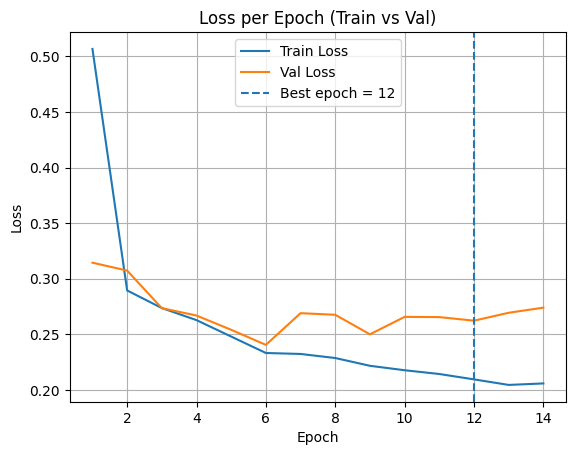

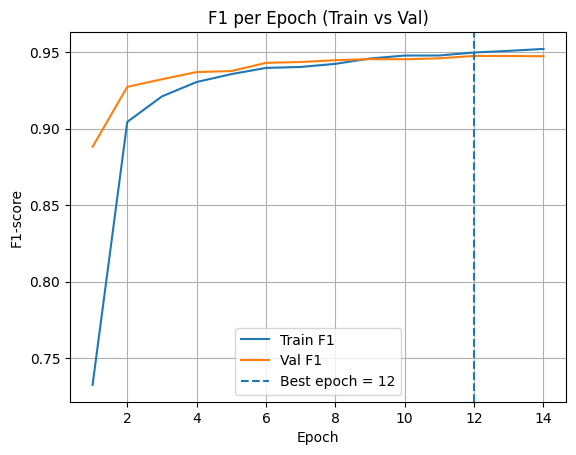

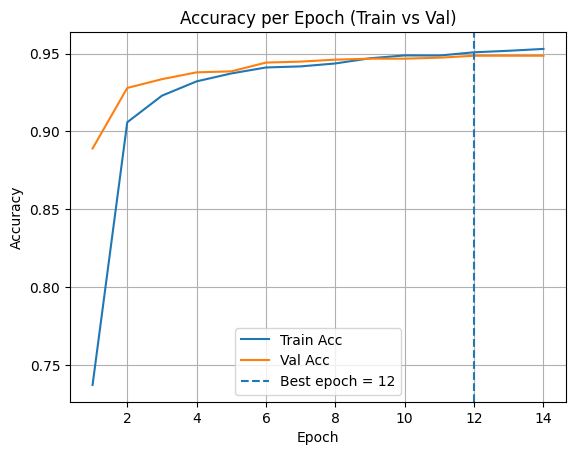

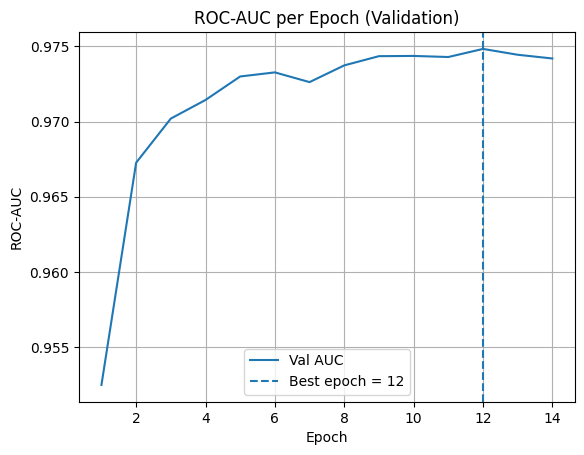

In [16]:
# Cell 11 — Train loop + early stopping (patience=2)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    all_logits, all_labels, running_loss = [], [], 0.0

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        outputs = model(**batch)
        logits = outputs.logits
        loss = criterion(logits, labels)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step(); scheduler.step()

        running_loss += loss.item() * labels.size(0)
        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    logits_np = np.concatenate(all_logits); labels_np = np.concatenate(all_labels)
    preds = np.argmax(logits_np, axis=-1); probs_pos = softmax_np(logits_np)[:,1]

    acc = accuracy_score(labels_np, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds, average="binary", zero_division=0)
    auc = roc_auc_score(labels_np, probs_pos)
    return {"loss": avg_loss, "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}

best_f1, patience, best_state, no_improve = -1, 2, None, 0
history = []
print("epoch |      TRAIN -> loss  acc   prec  rec   f1    |       VAL -> loss  acc   prec  rec   f1    auc")
for epoch in range(1, num_epochs+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    history.append({"epoch":epoch, **{f"train_{k}":v for k,v in tr.items()}, **{f"val_{k}":v for k,v in va.items()}})
    print(f"{epoch:>5} | TRAIN: {tr['loss']:.4f} {tr['acc']:.4f} {tr['prec']:.4f} {tr['rec']:.4f} {tr['f1']:.4f} | "
          f"VAL: {va['loss']:.4f} {va['acc']:.4f} {va['prec']:.4f} {va['rec']:.4f} {va['f1']:.4f} {va['auc']:.4f}")

    if va["f1"] > best_f1:
        best_f1 = va["f1"]; best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}; no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered."); break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print("Best Val F1:", best_f1)

# ringkasan per-epoch
try:
    hist_df = pd.DataFrame(history)
    print("\n=== Ringkasan per-epoch ==="); print(hist_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
except Exception: pass

# Cell 11A — Plot kurva Training vs Validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan hist_df ada; kalau belum, bangun dari 'history'
if "hist_df" not in globals():
    hist_df = pd.DataFrame(history)

assert not hist_df.empty, "hist_df kosong. Jalankan Cell 11 (training) dulu."

epochs = hist_df["epoch"].values
best_idx = hist_df["val_f1"].idxmax()
best_epoch = int(hist_df.loc[best_idx, "epoch"])
best_row = hist_df.loc[best_idx]

print("== Best (berdasarkan Val F1) ==")
print(best_row.to_string())

# 1) Loss
plt.figure()
plt.plot(epochs, hist_df["train_loss"], label="Train Loss")
plt.plot(epochs, hist_df["val_loss"],   label="Val Loss")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per Epoch (Train vs Val)")
plt.legend(); plt.grid(True)
plt.show()

# 2) F1-score
plt.figure()
plt.plot(epochs, hist_df["train_f1"], label="Train F1")
plt.plot(epochs, hist_df["val_f1"],   label="Val F1")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("F1-score"); plt.title("F1 per Epoch (Train vs Val)")
plt.legend(); plt.grid(True)
plt.show()

# 3) Accuracy
plt.figure()
plt.plot(epochs, hist_df["train_acc"], label="Train Acc")
plt.plot(epochs, hist_df["val_acc"],   label="Val Acc")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy per Epoch (Train vs Val)")
plt.legend(); plt.grid(True)
plt.show()

# 4) AUC (validasi saja—train AUC tidak selalu informatif)
plt.figure()
plt.plot(epochs, hist_df["val_auc"], label="Val AUC")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("ROC-AUC"); plt.title("ROC-AUC per Epoch (Validation)")
plt.legend(); plt.grid(True)
plt.show()


[TEST] Acc=0.9446  Prec=0.9585  Rec=0.9290  F1=0.9435  AUC=0.9770
Classification report:
              precision    recall  f1-score   support

     negatif     0.9316    0.9600    0.9456      2000
     positif     0.9585    0.9290    0.9435      1987

    accuracy                         0.9446      3987
   macro avg     0.9450    0.9445    0.9446      3987
weighted avg     0.9450    0.9446    0.9446      3987

Confusion matrix (rows=true, cols=pred):
 [[1920   80]
 [ 141 1846]]


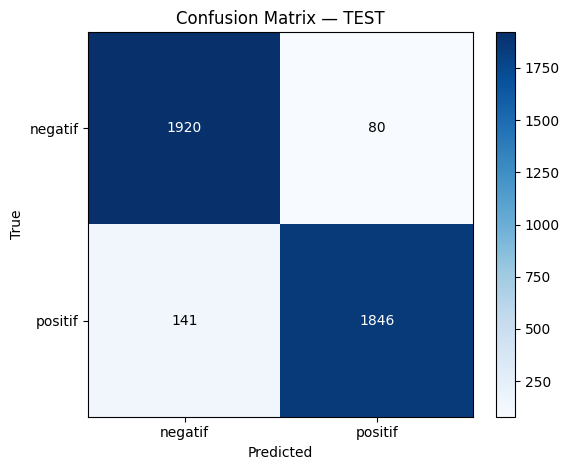

In [17]:
# Cell 12 — Eval + CM (Blues)
def eval_and_report_loader(split_name, loader, y_true_array):
    model.eval(); all_logits = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")
            all_logits.append(model(**batch).logits.detach().cpu().numpy())
    logits_np = np.concatenate(all_logits)
    probs_pos = softmax_np(logits_np)[:,1]; y_pred = (probs_pos >= 0.5).astype(int)

    acc  = accuracy_score(y_true_array, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true_array, y_pred, average="binary", zero_division=0)
    auc  = roc_auc_score(y_true_array, probs_pos)
    print(f"\n[{split_name}] Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    print("Classification report:")
    print(classification_report(y_true_array, y_pred, target_names=["negatif","positif"], digits=4, zero_division=0))

    cm = confusion_matrix(y_true_array, y_pred, labels=[0,1])
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(f"Confusion Matrix — {split_name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_xticklabels(["negatif","positif"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["negatif","positif"])
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc), probs_pos, y_pred

test_metrics, test_probs, test_pred = eval_and_report_loader("TEST", test_loader, y_test)

In [18]:
# Cell 20 — Save best model/checkpoint
from pathlib import Path
import json, time

# pastikan state "best" sudah diload ke model (sudah dilakukan di Cell 19)
ts = time.strftime("%Y%m%d-%H%M%S")
SAVE_DIR = Path(f"/kaggle/working/bert-sentiment-run-{ts}")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# simpan mapping label agar konsisten saat load
model.config.id2label = id2label
model.config.label2id = label2id

# 1) Simpan model & tokenizer dalam format Hugging Face
model.save_pretrained(SAVE_DIR)
try:
    tokenizer.save_pretrained(SAVE_DIR)
except NameError:
    pass

# 2) Simpan riwayat training (jika tersedia)
try:
    hist_df.to_csv(SAVE_DIR/"train_history.csv", index=False)
except Exception:
    pass

# 3) (Opsional) Simpan checkpoint PyTorch untuk resume training
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "config": model.config.to_dict(),
    "id2label": id2label,
    "label2id": label2id,
}, SAVE_DIR/"checkpoint.pt")

# 4) Metadata ringkas
meta = {
    "model_name": MODEL_NAME,
    "num_labels": model.config.num_labels,
    "best_val_f1": float(best_f1),
    "epochs_trained": int(hist_df["epoch"].max()) if "hist_df" in globals() else None,
    "batch_size": int(train_loader.batch_size),
}
with open(SAVE_DIR/"meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"Model & artefak disimpan ke: {SAVE_DIR.resolve()}")

Model & artefak disimpan ke: /kaggle/working/bert-sentiment-run-20251031-170126


In [21]:
# Cell XX — Error Analysis: identifikasi kesalahan model (FP & FN)
import pandas as pd
import numpy as np

# Pastikan y_test dan test_pred sudah tersedia dari evaluasi sebelumnya
assert len(y_test) == len(test_pred), "Pastikan evaluasi sudah dijalankan lebih dulu!"

# Buat DataFrame hasil prediksi
err_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test.astype(int),
    "pred_label": test_pred.astype(int)
})

# Tambahkan probabilitas jika ada (opsional, dari test_probs)
if 'test_probs' in locals():
    if test_probs.ndim == 2 and test_probs.shape[1] == 2:
        err_df["proba_neg"] = test_probs[:,0]
        err_df["proba_pos"] = test_probs[:,1]

# Tentukan tipe kesalahan
def error_type(row):
    if row["true_label"] == 1 and row["pred_label"] == 0:
        return "FN"  # False Negative
    elif row["true_label"] == 0 and row["pred_label"] == 1:
        return "FP"  # False Positive
    else:
        return "OK"  # Benar

err_df["error_type"] = err_df.apply(error_type, axis=1)

# Ringkasan umum
print("=== Error Type Distribution ===")
print(err_df["error_type"].value_counts(), "\n")

# Contoh kesalahan model
print("=== Contoh False Positive (FP) ===")
print(err_df[err_df["error_type"]=="FP"].head(10)[["text","true_label","pred_label"]].to_string(index=False))

print("\n=== Contoh False Negative (FN) ===")
print(err_df[err_df["error_type"]=="FN"].head(10)[["text","true_label","pred_label"]].to_string(index=False))

# Simpan ke file untuk analisis lebih lanjut
out_path = "error_analysis.csv"
err_df.to_csv(out_path, index=False)
print(f"\nFile error analysis disimpan di: {out_path}")

=== Error Type Distribution ===
error_type
OK    3766
FN     141
FP      80
Name: count, dtype: int64 

=== Contoh False Positive (FP) ===
                                                         text  true_label  pred_label
                                                      web lot           0           1
                                                       mantap           0           1
lumayan bagus ribetnya tiap bulan masuk verifikasi data ulang           0           1
                                            klo bintang kasih           0           1
                                            nda bsa pindah hp           0           1
                                  susah mengupdate jkn mobile           0           1
                                                    mumet joh           0           1
                        sering ngebug tidak pusat bantu bantu           0           1
                                                    tida suka           0           1
 

In [ ]:
# ==== Mount Google Drive ====
from google.colab import drive
drive.mount('/content/drive')  # authorize di popup

Mounted at /content/drive


In [ ]:
!pip -q install pandas numpy scikit-learn Sastrawi tqdm joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


In [20]:
# Cell 21 — Load model/tokenizer untuk inference
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import os, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1) device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

LOAD_DIR = str("/kaggle/working/bert-sentiment-run-20251031-170126")  # atau set manual ke folder model yang ingin dipakai
print("Load dari:", LOAD_DIR)

tokenizer_inf = AutoTokenizer.from_pretrained(LOAD_DIR, use_fast=True)
model_inf = AutoModelForSequenceClassification.from_pretrained(LOAD_DIR).to(device)
model_inf.eval()

# pastikan mapping label tersedia
id2label_inf = model_inf.config.id2label
label2id_inf = model_inf.config.label2id
print("id2label:", id2label_inf)

# Cell 22 — Preprocess (Sastrawi) + Inference (batch teks dari user)
import re, numpy as np, pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import torch

# ---------- PREPROCESS: sama dengan sebelumnya ----------
_stopwords = set(StopWordRemoverFactory().get_stop_words())
negators = {"tidak","nggak","gak","ga","gk","tak","enggak","bukan","belum","jangan","tanpa","kurang"}
_stopwords = _stopwords - negators

SLANG_MAP = {
    "ga":"tidak","gk":"tidak","gak":"tidak","ngga":"tidak","nggak":"tidak",
    "enggak":"tidak","kagak":"tidak","tdk":"tidak","tak":"tidak"
}
_stemmer = StemmerFactory().create_stemmer()

def normalize_text(s: str) -> str:
    s = s.lower()
    for k,v in SLANG_MAP.items():
        s = re.sub(rf"\b{k}\b", v, s)
    s = re.sub(r'http\S+|www\.\S+',' ', s)   # URL
    s = re.sub(r'@\w+|#\w+',' ', s)          # mention/hashtag
    s = re.sub(r'\d+',' ', s)                # angka
    s = re.sub(r'[^\w\s!?]', ' ', s)         # simbol/emoji (keep !?)
    s = re.sub(r'\s+',' ', s).strip()
    return s

def remove_stopwords(tokens):
    return [t for t in tokens if t not in _stopwords and len(t) > 1]

def preprocess_id(text: str, use_stemming: bool=True) -> str:
    t = normalize_text(text)
    tokens = t.split()
    tokens = remove_stopwords(tokens)
    if use_stemming:
        tokens = [_stemmer.stem(tok) for tok in tokens]
        tokens = [tok for tok in tokens if len(tok) > 1]
    return " ".join(tokens)

def softmax_np(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

# ---------- AMBIL INPUT USER ----------
print("Masukkan teks (multi-baris). ENTER kosong untuk selesai:")
lines = []
while True:
    try:
        s = input()
    except EOFError:
        break
    if s is None or s.strip() == "":
        break
    lines.append(s)

if not lines:
    raise SystemExit("Tidak ada input.")

# ---------- PREPROCESS ----------
df_in = pd.DataFrame({"original_text": lines})
df_in["preprocessed"] = df_in["original_text"].apply(lambda s: preprocess_id(s, use_stemming=True))
mask_valid = df_in["preprocessed"].str.len() > 2

# siapkan kolom hasil
df_in["pred_id"] = np.nan
df_in["pred_label"] = "terlalu pendek (<3 char)"
df_in["proba_negatif"] = np.nan
df_in["proba_positif"] = np.nan  # biner; jika nanti 3-label, tambahkan proba_netral

if mask_valid.any():
    # Tokenize (padding ke batch, truncation sesuai max_length tokenizer default)
    enc = tokenizer_inf(
        df_in.loc[mask_valid, "preprocessed"].tolist(),
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        out = model_inf(**enc)
        logits = out.logits.detach().cpu().numpy()
        probs = softmax_np(logits)  # shape: (n, num_labels)

    # mapping id->label dari config yang tersimpan
    classes = list(range(probs.shape[1]))  # [0,1] untuk biner
    id2name = {int(k): v for k, v in id2label_inf.items()}  # contoh: {0:'negatif', 1:'positif'}

    pred_ids = probs.argmax(axis=1)
    pred_labels = [id2name[int(i)] for i in pred_ids]

    df_in.loc[mask_valid, "pred_id"] = pred_ids
    df_in.loc[mask_valid, "pred_label"] = pred_labels

    # simpan probabilitas (biner: asumsi 0=negatif, 1=positif)
    colmap = {0: "proba_negatif", 1: "proba_positif"}
    for cls in classes:
        colname = colmap.get(cls, f"proba_cls{cls}")
        df_in.loc[mask_valid, colname] = probs[:, cls]

# ---------- OUTPUT ----------
print("\n=== HASIL KLASIFIKASI (Biner) ===")
print(df_in[["original_text", "preprocessed", "pred_id", "pred_label", "proba_negatif", "proba_positif"]])

Device: cuda
Load dari: /kaggle/working/bert-sentiment-run-20251031-170126
id2label: {0: 'negatif', 1: 'positif'}
Masukkan teks (multi-baris). ENTER kosong untuk selesai:


 aufa senang dengan aplikasinya
 



=== HASIL KLASIFIKASI (Biner) ===
                    original_text          preprocessed  pred_id pred_label  \
0  aufa senang dengan aplikasinya  aufa senang aplikasi      1.0    positif   

   proba_negatif  proba_positif  
0       0.001631       0.998369  
